📊 데이터셋 설명
================================================================================

파일명: scaling_practice.csv
데이터 개수: 100개 직장인 데이터 (8개 이상치 포함)
컬럼 구성:
  - employee_id: 직원 ID (2001~2100)
  - age: 나이 (20~60세) ← 수치형 📊
  - years_experience: 근무 경력 (0~40년) ← 수치형 📊
  - commute_distance: 통근 거리 (1~150km, 이상치 포함) ← 수치형 📊
  - house_price: 집값 (1000~50000만원, 이상치 포함) ← 수치형 📊
  - salary: 연봉 (5000~35000만원, 예측 대상, 이상치 포함) ← 수치형 📊

데이터 특징:
  ✅ 나이와 경력은 양의 상관관계 (나이 많으면 경력도 많음)
  ✅ 경력과 연봉은 양의 상관관계 (경력 많으면 연봉도 높음)
  ✅ 연봉과 집값은 양의 상관관계 (연봉 높으면 집도 비쌈)
  ✅ 통근거리는 독립적
  ⚠️ 이상치 8개 포함 (연봉 3억, 집값 5억, 통근거리 150km 등)

🔧 실습 1: 데이터 불러오기 및 스케일 차이 확인
================================================================================

In [2]:
import pandas as pd
import numpy as np

# 데이터 불러오기
df = pd.read_csv('./data/raw/scaling_practice.csv')

# 데이터 미리보기
print(df.head(10))

# 데이터 통계 확인
print("\n각 변수의 통계:")
print(df.describe())

# 범위(Range) 확인 - 스케일 차이를 직접 확인!
print("\n각 변수의 범위 (최댓값 - 최솟값):")
for col in ['age', 'years_experience', 'commute_distance', 'house_price', 'salary']:
    range_val = df[col].max() - df[col].min()
    print(f"  {col:20s}: {range_val:>10,.1f}")

print("\n💡 관찰 포인트:")
print("  - house_price 범위: 약 47,000 (4.7억원 차이)")
print("  - salary 범위: 약 30,000 (3억원 차이)")
print("  - age 범위: 약 40 (40세 차이)")
print("  - commute_distance 범위: 약 150 (150km 차이)")
print("  → 변수마다 스케일(범위)이 천 배 이상 차이남!")
print("  → 이 상태로 모델 학습하면 큰 값의 변수가 지배함!")

   employee_id  age  years_experience  commute_distance  house_price   salary
0         2001   58                34              36.9       6412.0  14717.0
1         2002   48                23               7.3       5234.0  11330.0
2         2003   34                15              13.3       3908.0   7408.0
3         2004   27                 8              29.4       3591.0   8664.0
4         2005   40                28              43.5       5683.0  13385.0
5         2006   58                40              28.5       6978.0  16973.0
6         2007   38                17              12.7       4793.0  10918.0
7         2008   42                19              34.3       5553.0   9645.0
8         2009   30                16              37.3       4189.0   9042.0
9         2010   30                12              12.7       4109.0   9057.0

각 변수의 통계:
       employee_id        age  years_experience  commute_distance  \
count   100.000000  100.00000        100.000000        100.000

🔧 실습 2: 스케일링 없이 거리 계산 (문제 상황)
================================================================================

In [3]:
from sklearn.metrics.pairwise import euclidean_distances

# 임의의 두 직원 선택
person_A = df.iloc[0][['age', 'commute_distance', 'house_price']].values
person_B = df.iloc[1][['age', 'commute_distance', 'house_price']].values

print("Person A:", person_A)
print("Person B:", person_B)

# 유클리드 거리 계산
distance = np.sqrt(np.sum((person_A - person_B) ** 2))
print(f"\n두 사람 사이의 거리 (스케일링 전): {distance:,.2f}")

# 각 변수의 기여도 확인
diff_age = (person_A[0] - person_B[0]) ** 2
diff_commute = (person_A[1] - person_B[1]) ** 2
diff_house = (person_A[2] - person_B[2]) ** 2

print("\n각 변수의 거리 제곱 기여도:")
print(f"  age 차이^2:              {diff_age:>12,.2f}")
print(f"  commute_distance 차이^2: {diff_commute:>12,.2f}")
print(f"  house_price 차이^2:      {diff_house:>12,.2f}")
print(f"  합계:                    {diff_age + diff_commute + diff_house:>12,.2f}")

print("\n⚠️ 문제 발견!")
print(f"  house_price가 전체 거리의 {diff_house/(diff_age + diff_commute + diff_house)*100:.1f}% 차지!")
print("  → 집값이 거리 계산을 지배해버림!")

Person A: [  58.    36.9 6412. ]
Person B: [  48.     7.3 5234. ]

두 사람 사이의 거리 (스케일링 전): 1,178.41

각 변수의 거리 제곱 기여도:
  age 차이^2:                    100.00
  commute_distance 차이^2:       876.16
  house_price 차이^2:      1,387,684.00
  합계:                    1,388,660.16

⚠️ 문제 발견!
  house_price가 전체 거리의 99.9% 차지!
  → 집값이 거리 계산을 지배해버림!


🔧 실습 3: StandardScaler 적용 (표준화)
================================================================================

In [22]:
from sklearn.preprocessing import StandardScaler

# 수치형 변수만 선택
numeric_cols = ['age', 'years_experience', 'commute_distance', 'house_price', 'salary']
X = df[numeric_cols]

# StandardScaler 적용
scaler_std = StandardScaler()
X_std = scaler_std.fit_transform(X)

# 데이터프레임으로 변환
df_std = pd.DataFrame(X_std, columns=numeric_cols)

print("StandardScaler 적용 후 데이터 (처음 5행):")
print(df_std.head())

print("\nStandardScaler 적용 후 통계:")
print(df_std.describe())

print("\n✅ 확인 포인트:")
print("  - 평균(mean): 모두 약 0에 가까움 (1e-16은 거의 0)")
print("  - 표준편차(std): 모두 1에 가까움")
print("  - 공식: z = (x - μ) / σ")

# 저장된 평균과 표준편차 확인
print("\n스케일러가 학습한 통계값:")
print(f"  평균(mean): {scaler_std.mean_}")
print(f"  표준편차(scale): {scaler_std.scale_}")

StandardScaler 적용 후 데이터 (처음 5행):
        age  years_experience  commute_distance  house_price    salary
0  1.625937          1.074596          0.358677    -0.097994  0.458908
1  0.772874          0.128951         -1.082263    -0.244250 -0.180309
2 -0.421413         -0.558790         -0.790180    -0.408882 -0.920495
3 -1.018556         -1.160563         -0.006426    -0.448240 -0.683455
4  0.090425          0.558790          0.679968    -0.188504  0.207524

StandardScaler 적용 후 통계:
                age  years_experience  commute_distance   house_price  \
count  1.000000e+02      1.000000e+02      1.000000e+02  1.000000e+02   
mean   2.142730e-16      1.054712e-17     -3.602674e-16  5.460910e-17   
std    1.005038e+00      1.005038e+00      1.005038e+00  1.005038e+00   
min   -1.615700e+00     -1.848304e+00     -1.286720e+00 -5.930060e-01   
25%   -9.332501e-01     -7.522169e-01     -6.806493e-01 -3.463692e-01   
50%    4.777149e-02     -8.596765e-02     -7.944640e-02 -1.674597e-01   
75%  

🔧 실습 4: MinMaxScaler 적용 (정규화)
================================================================================

In [23]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 적용
scaler_mm = MinMaxScaler()
X_mm = scaler_mm.fit_transform(X)

# 데이터프레임으로 변환
df_mm = pd.DataFrame(X_mm, columns=numeric_cols)

print("MinMaxScaler 적용 후 데이터 (처음 5행):")
print(df_mm.head())

print("\nMinMaxScaler 적용 후 통계:")
print(df_mm.describe())

print("\n✅ 확인 포인트:")
print("  - 최솟값(min): 모두 0")
print("  - 최댓값(max): 모두 1")
print("  - 공식: (x - x_min) / (x_max - x_min)")

# 이상치 영향 확인
print("\n⚠️ 이상치 영향 확인:")
print("  salary의 25%~75% 범위:", df_mm['salary'].quantile([0.25, 0.75]).values)
print("  house_price의 25%~75% 범위:", df_mm['house_price'].quantile([0.25, 0.75]).values)
print("  → 이상치 때문에 정상 데이터가 0~0.3 사이에 뭉쳐있음!")

MinMaxScaler 적용 후 데이터 (처음 5행):
     age  years_experience  commute_distance  house_price    salary
0  0.950             0.850          0.230088     0.083805  0.323900
1  0.700             0.575          0.028591     0.059044  0.211000
2  0.350             0.375          0.069435     0.031172  0.080267
3  0.175             0.200          0.179033     0.024509  0.122133
4  0.500             0.700          0.275017     0.068481  0.279500

MinMaxScaler 적용 후 통계:
              age  years_experience  commute_distance  house_price      salary
count  100.000000        100.000000        100.000000   100.000000  100.000000
mean     0.473500          0.537500          0.179932     0.100395    0.242847
std      0.294538          0.292272          0.140542     0.170151    0.177512
min      0.000000          0.000000          0.000000     0.000000    0.000000
25%      0.200000          0.318750          0.084752     0.041755    0.123883
50%      0.487500          0.512500          0.168822     0.0720

🔧 실습 5: RobustScaler 적용 (이상치 강건)
================================================================================

In [24]:
from sklearn.preprocessing import RobustScaler

# RobustScaler 적용
scaler_rb = RobustScaler()
X_rb = scaler_rb.fit_transform(X)

# 데이터프레임으로 변환
df_rb = pd.DataFrame(X_rb, columns=numeric_cols)

print("RobustScaler 적용 후 데이터 (처음 5행):")
print(df_rb.head())

print("\nRobustScaler 적용 후 통계:")
print(df_rb.describe())

print("\n✅ 확인 포인트:")
print("  - 중앙값(50%) 근처: 0에 가까움")
print("  - 25%~75% 범위: 약 -0.5 ~ 0.5")
print("  - 공식: (x - Q2) / (Q3 - Q1)")
print("  - 이상치 영향 최소화!")

RobustScaler 적용 후 데이터 (처음 5행):
        age  years_experience  commute_distance  house_price    salary
0  0.961039          0.739726             0.360     0.220841  0.475357
1  0.441558          0.136986            -0.824    -0.244129 -0.022566
2 -0.285714         -0.301370            -0.584    -0.767515 -0.599140
3 -0.649351         -0.684932             0.060    -0.892639 -0.414495
4  0.025974          0.410959             0.624    -0.066903  0.279540

RobustScaler 적용 후 통계:
              age  years_experience  commute_distance  house_price      salary
count  100.000000        100.000000      1.000000e+02   100.000000  100.000000
mean    -0.029091          0.054795      6.528000e-02     0.532378    0.117887
std      0.612028          0.640596      8.258256e-01     3.195157    0.782883
min     -1.012987         -1.123288     -9.920000e-01    -1.352872   -0.953141
25%     -0.597403         -0.424658     -4.940000e-01    -0.568778   -0.406777
50%      0.000000          0.000000      7.112

🔧 실습 6: 3가지 스케일러 시각적 비교
================================================================================

/tmp/ipython-input-2141686591.py:42: UserWarning: Glyph 47564 (\N{HANGUL SYLLABLE MAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2141686591.py:42: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47564 (\N{HANGUL SYLLABLE MAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


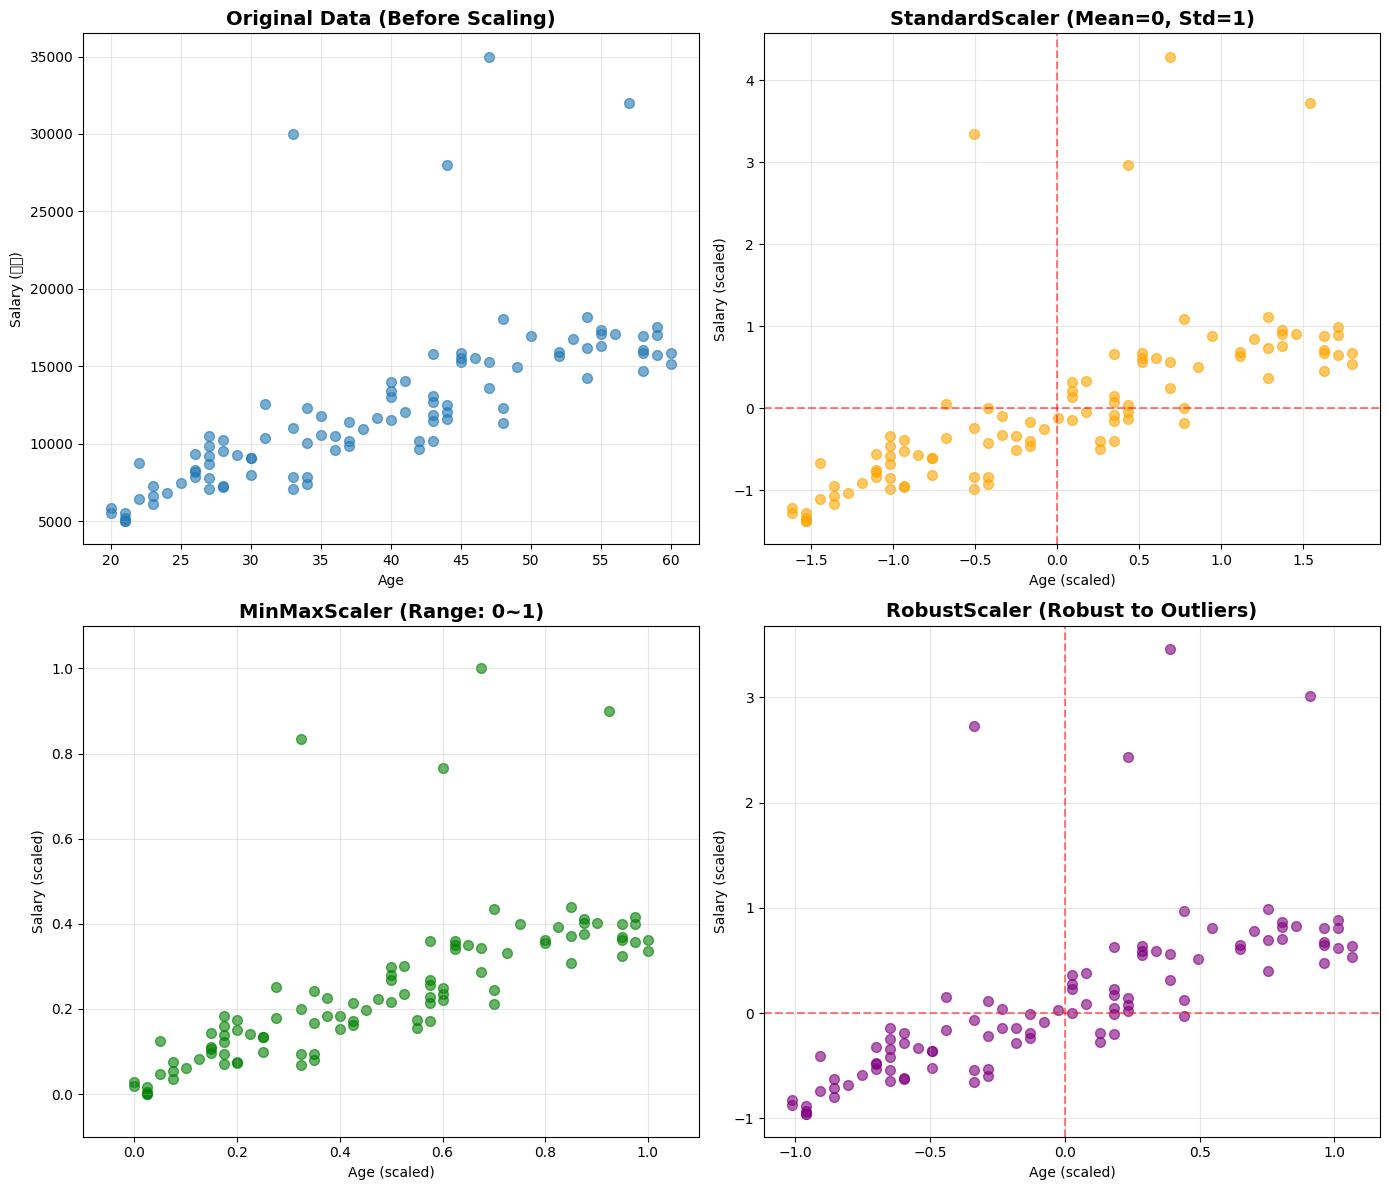


✅ 시각화 완료!

관찰 포인트:
  1. 원본: 연봉이 너무 커서 y축이 0~35000 (age는 20~60)
  2. Standard: 중심이 (0, 0)으로 이동, 이상치가 멀리 떨어짐
  3. MinMax: 0~1 상자 안에 압축, 이상치 때문에 정상 데이터가 뭉침
  4. Robust: 이상치 영향 최소화, 정상 데이터가 고르게 분포


In [25]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

# 2개 변수 선택 (나이 vs 연봉)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. 원본 데이터
axes[0, 0].scatter(df['age'], df['salary'], alpha=0.6, s=50)
axes[0, 0].set_title('Original Data (Before Scaling)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Salary (만원)')
axes[0, 0].grid(alpha=0.3)

# 2. StandardScaler
axes[0, 1].scatter(df_std['age'], df_std['salary'], alpha=0.6, s=50, color='orange')
axes[0, 1].set_title('StandardScaler (Mean=0, Std=1)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Age (scaled)')
axes[0, 1].set_ylabel('Salary (scaled)')
axes[0, 1].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].grid(alpha=0.3)

# 3. MinMaxScaler
axes[1, 0].scatter(df_mm['age'], df_mm['salary'], alpha=0.6, s=50, color='green')
axes[1, 0].set_title('MinMaxScaler (Range: 0~1)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Age (scaled)')
axes[1, 0].set_ylabel('Salary (scaled)')
axes[1, 0].set_xlim(-0.1, 1.1)
axes[1, 0].set_ylim(-0.1, 1.1)
axes[1, 0].grid(alpha=0.3)

# 4. RobustScaler
axes[1, 1].scatter(df_rb['age'], df_rb['salary'], alpha=0.6, s=50, color='purple')
axes[1, 1].set_title('RobustScaler (Robust to Outliers)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Age (scaled)')
axes[1, 1].set_ylabel('Salary (scaled)')
axes[1, 1].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ 시각화 완료!")
print("\n관찰 포인트:")
print("  1. 원본: 연봉이 너무 커서 y축이 0~35000 (age는 20~60)")
print("  2. Standard: 중심이 (0, 0)으로 이동, 이상치가 멀리 떨어짐")
print("  3. MinMax: 0~1 상자 안에 압축, 이상치 때문에 정상 데이터가 뭉침")
print("  4. Robust: 이상치 영향 최소화, 정상 데이터가 고르게 분포")

🔧 실습 7: Train/Test Split 후 스케일링 (Data Leakage 방지)
================================================================================

In [26]:
from sklearn.model_selection import train_test_split

# 특성(X)과 타깃(y) 분리
X = df[['age', 'years_experience', 'commute_distance', 'house_price']]
y = df['salary']

# 1. 먼저 데이터 분리 (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=42)

print(f"Train 데이터: {X_train.shape[0]}개")
print(f"Test 데이터: {X_test.shape[0]}개")

# 2. Train 데이터에만 fit
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # ✅ fit_transform
X_test_scaled = scaler.transform(X_test)        # ✅ transform만

print(f"\n✅ Data Leakage 방지 완료!")
print(f"Train 스케일링: {X_train_scaled.shape}")
print(f"Test 스케일링: {X_test_scaled.shape}")

# Train 데이터의 통계로 Test 변환
print(f"\nTrain 평균: {scaler.mean_}")
print(f"Train 표준편차: {scaler.scale_}")
print("→ Test 데이터는 Train의 평균/표준편차로 변환됨!")

# ⚠️ 잘못된 방법 (절대 하지 마세요!)
print("\n⚠️ 잘못된 방법 (Data Leakage 발생):")
print("# X_scaled = scaler.fit_transform(X)  ❌ 전체 데이터에 fit")
print("# X_train, X_test = train_test_split(X_scaled)  ❌ Test 정보 누수!")

Train 데이터: 80개
Test 데이터: 20개

✅ Data Leakage 방지 완료!
Train 스케일링: (80, 4)
Test 스케일링: (20, 4)

Train 평균: [  38.575   21.125   29.88  7547.825]
Train 표준편차: [  11.50844798   11.41640815   21.58519979 8933.46231701]
→ Test 데이터는 Train의 평균/표준편차로 변환됨!

⚠️ 잘못된 방법 (Data Leakage 발생):
# X_scaled = scaler.fit_transform(X)  ❌ 전체 데이터에 fit
# X_train, X_test = train_test_split(X_scaled)  ❌ Test 정보 누수!


📝 핵심 요약
================================================================================

✅ 스케일링이 필요한 이유:
   - 변수마다 범위(Scale)가 다르면 큰 값이 학습을 지배
   - 거리 기반 알고리즘(KNN, K-Means)에서 특히 중요
   - 경사하강법(신경망, 로지스틱)에서도 필수

✅ 스케일러 선택 기준:
   - 이상치 많음 → RobustScaler
   - 일반적 상황 → StandardScaler
   - 이미지/딥러닝 → MinMaxScaler
   - 트리 모델 → 스케일링 불필요!

✅ Data Leakage 방지:
   - Train에만 fit → Test는 transform만
   - 절대 전체 데이터에 fit 금지!